# Projet 3A SN :  Détection d'activité humaine - Apprentissage supervisé et non supervisé



Dans ce projet, nous essaierons de prédire l'activité humaine (1-Descendre, 2-Courir, 3-Assis, 4-Debout, 5-Monter ou 6-Marcher) en utilisant les capteurs du smartphone. C'est-à-dire qu'en utilisant les méthodes suivantes, le smartphone peut détecter ce que nous faisons en ce moment.


En utilisant l'accéléromètre  intégré dans le smartphone,  l'accélération linéaire 3-axes à un taux constant de 50Hz ont été relevées. Les expériences ont été enregistrées sur vidéo pour étiqueter les données manuellement. 

<img src="files/HARDataset.JPG" width="800" height="600"  >

Il est fourni pour chaque enregistrement de l'ensemble de données : 
- L'accélération triaxiale de l'accéléromètre (accélération totale)
- Son étiquette d'activité. 
- Un identifiant du sujet qui a réalisé l'expérience.


Ces 5 séances se décomposent en 4 parties : 
- Partie I : Implémenter la DTW pour créer un système de reconnaissance;
- Partie II : Réduction de dimension par ACP et classification par kppv 
- Partie III : Classification par Forêts aléatoires
- Partie IV : Classification par réseaux de neurones
- Partie V : Votre étude

**Travail à rendre**

Pour cela, vous devez par binômes (effectif **OBLIGATOIRE**):
1. Implémenter la DTW pour créer un système de reconnaissance;
2. Evaluer les résultats en utilisant la matrice de confusion et le pourcentage de bonne classification;
3. Réduction de dimension par ACP et classification par kppv 
4. Classification par Forêts aléatoires
5. Classification par réseaux de neurones
6. Rédiger un rapport en pdf présentant votre étude : les résultats par  méthode et vos commentaires et conclusions sur une étude plus générale en modifiant les tailles des ensembles de test et d'apprentissage, en changeant le nombre de classes  (Longeur max. : 10 pages).


**Dataset et description :**
https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns

In [2]:
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = './WISDM_ar_v1.1_raw.txt'


# Data preprocessing
TIME_STEP = 60

# Model
N_CLASSES = 3
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_TIME_SIZE = 30
TAILLE_TEST=40
TAILLE_APP=20

## 1. Création des données d'apprentissage et de test

In [3]:
from google.colab import files
uploaded = files.upload()

Saving WISDM_ar_v1.1_raw.txt to WISDM_ar_v1.1_raw.txt


Convoluted data shape:  (8376, 30, 3)
Labels shape: (8376,)
Classe N° 0
shape de tir data test (40, 30, 3)
shape de tir data app (20, 30, 3)
Classe N° 1
shape de tir data test (40, 30, 3)
shape de tir data app (20, 30, 3)
Classe N° 2
shape de tir data test (40, 30, 3)
shape de tir data app (20, 30, 3)


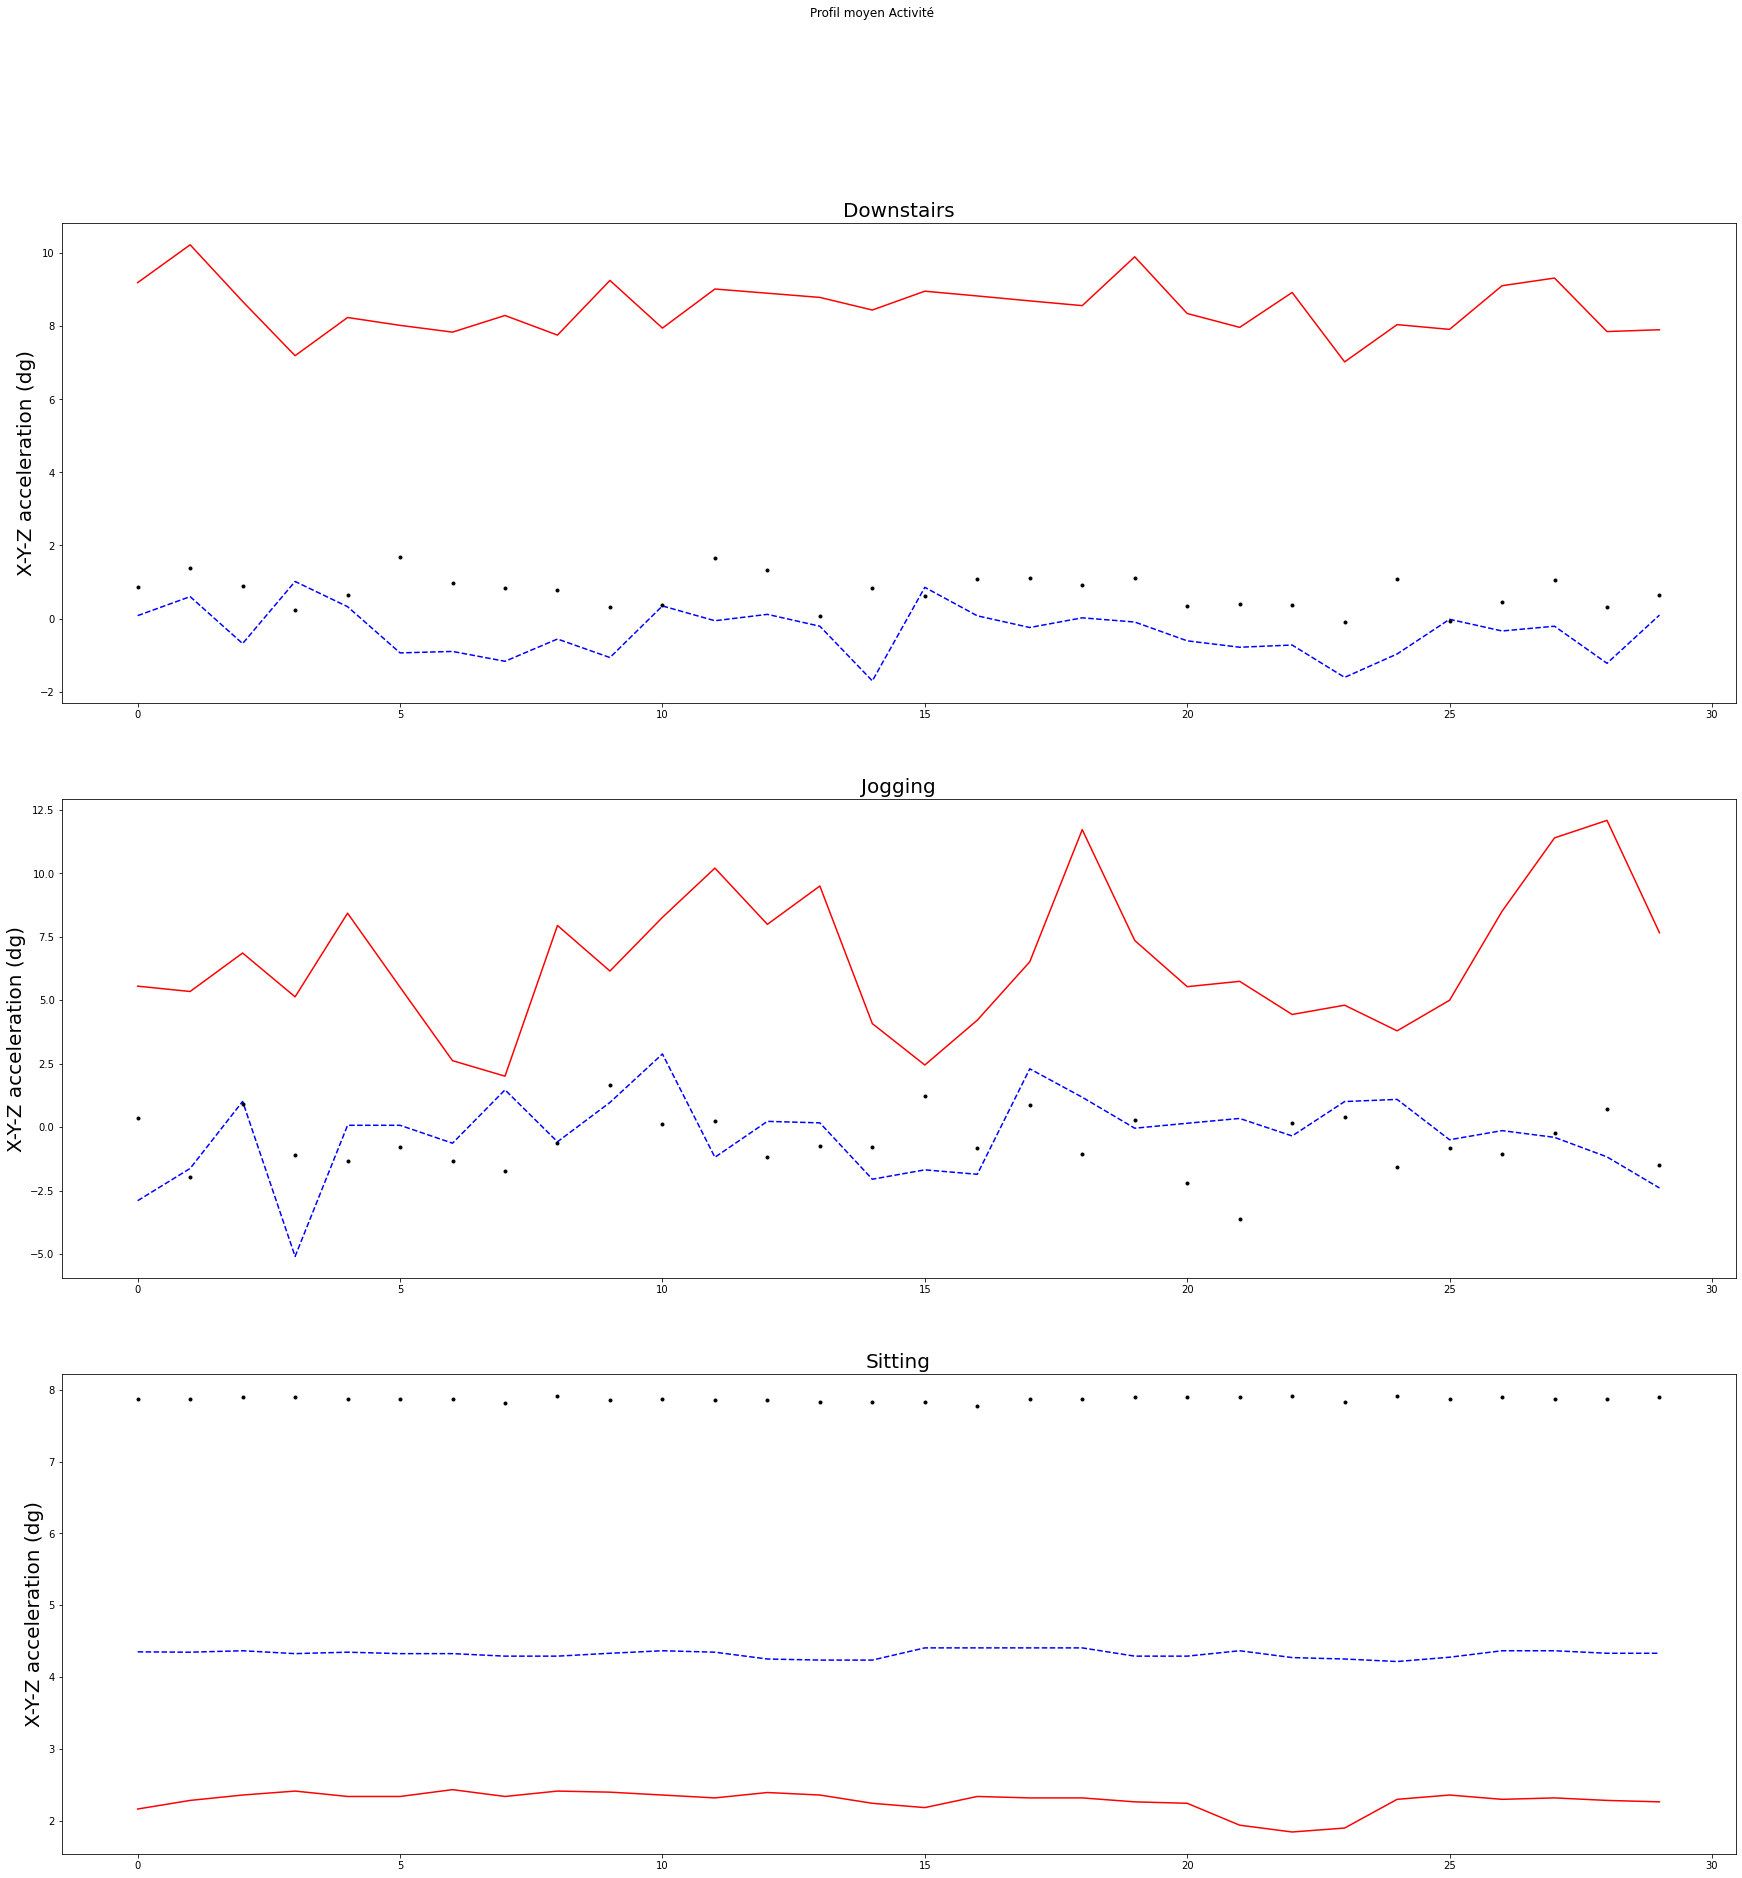

In [4]:
# Chargement DATA
data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()


data_convoluted = []
labels = []



# Prendre des segments temporels de taille SEGMENT_TIME_SIZE 
# tous les TIME_STEP pour une même activité
for j in range(0,N_CLASSES):
    DataBest=data[data['activity'] == LABELS[j]]
    for i in range(0, len(DataBest) - SEGMENT_TIME_SIZE, TIME_STEP):
        x = DataBest['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
        y = DataBest['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
        z = DataBest['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
        data_convoluted.append([x, y, z])
    # Label de l'activité associée à chaque segment
        label = j
        labels.append(label)


# Conversion numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

labels = np.asarray(labels, dtype=np.int)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)


fig, axs = plt.subplots(N_CLASSES,figsize=(30,30))
fig.suptitle('Profil moyen Activité')

profil_median=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_Data_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)

for i in range(N_CLASSES):
    # Selection des données correspondant à la classe i
    print('Classe N°',i)
    res=np.where(labels==i)
    res=np.array(res)
    res=np.ravel(res)
    taille=res.shape[0]
    
    # Création de la base de Test
    tirage=np.random.randint(0,taille,TAILLE_TEST)
    List_Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=res[tirage[0:TAILLE_TEST]]
    Label_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=i
    tir_dataTest=data_convoluted[res[tirage[0:TAILLE_TEST]],:,:]
    Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST,:]=np.reshape(tir_dataTest,(TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
    
    
    # Création de la base d'Apprentissage
    tirage1=np.random.randint(0,taille,TAILLE_APP)
    tir_dataApp=data_convoluted[res[tirage1[0:TAILLE_APP]],:,:]
    Data_App[i*TAILLE_APP:(i+1)*TAILLE_APP,:]=np.reshape(tir_dataApp,(TAILLE_APP,SEGMENT_TIME_SIZE*N_FEATURES))
    Label_App[i*TAILLE_APP:(i+1)*TAILLE_APP]=i
    
    # Affichage du profil temporel moyen de la classe
    class1=np.median(tir_dataApp,axis=0)
    profil_median[i,:,:]=class1
    
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,0],'b--')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,1],'r-')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,2],'k.')
    axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
    axs[i].set_title(LABELS[i], fontsize=20)

    print("shape de tir data test", np.shape(tir_dataTest))
    print("shape de tir data app", np.shape(tir_dataApp))




In [5]:
print("x shape", np.shape(x))
print("Convoluted data shape: ", data_convoluted.shape)


x shape (30,)
Convoluted data shape:  (8376, 30, 3)


# Partie I : Implémentation de l'algorithme de programmation dynamique 

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en CTD. 

On utilise une distance L1

In [6]:
def dist(p1,p2):
  return abs(p1-p2)

In [7]:

def DTW_Matrix(A,B):
    M = len(A) # longueur de la première série
    N = len(B) # longueur de la deuxième série
    g = np.zeros((N,M),dtype=float) # initialisation de la matrice DTW
    
    for i in range(1,M):
        g[0,i] = dist(A[i],B[0]) + g[0,i-1]
    for i in range(1,N):
        g[i,0] = dist(A[0],B[i]) + g[i-1,0]
    for i in range(1,N):
        for j in range(1,M):
            cost = dist(A[j],B[i])
            g[i,j] = np.min([g[i-1,j] + cost, g[i,j-1] + cost, g[i-1,j-1] + cost])
    
    return g

In [8]:
def score_DTW(g):
  N = np.shape(g)[0]
  M = np.shape(g)[1]

  return g[N-1,M-1]

In [9]:
# Test de DTW
A = np.array([0,1,1,2,2,3,5])
B = np.array([0,1,2,3,5,5,5,6])
g = DTW_Matrix(A, B)

score_DTW(g)

1.0

2. Pour chaque profil temporel test :

a) Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe 

b) Déterminer la classe d'appartenance par minimum du score sur toutes les classes




In [10]:
print("x shape", np.shape(x))
print("Convoluted data shape: ", data_convoluted.shape)
print("data_app size", np.shape(Data_App))
print("data test size", np.shape(Data_Test))
print("label test size", np.shape(Label_Test))
print("Label App size", np.shape(Label_App))
print("profil_median", np.shape(profil_median))
print("class1", np.shape(class1))

x shape (30,)
Convoluted data shape:  (8376, 30, 3)
data_app size (60, 90)
data test size (120, 90)
label test size (120,)
Label App size (60,)
profil_median (3, 30, 3)
class1 (30, 3)


Ce que nous comprenons des données :


*   data_convoluted, c'est 8376 profils temporels de taille 30 chacun, associés aux axes x, y, z (3e coordonnée)
*   En utilisant le vecteur "labels" on peut relier une donnée de data_convoluted à son label
*   data_test c'est 40 * 3 données de data_convoluted (40 par classes) ou on a pour chacune le profil temporel selon x, y et z (de taille 30 chacun)
*   data_app c'est 20 *3 données de data_convoluted (20 par classes), selectionné au hasard, ou on a pour chacune le profil temporel selon x, y et z (de taille 30 chacun)
*   label_median c'est le profil médian pour chacune des classes (coordonnée1) sur les axes x y et z (coordonnées 3)










In [11]:
# Les données d'apprentissage de label 0
Data_App_0 = Data_App[0:20, :]
print("Data_App_0 size :", np.shape(Data_App_0))

# Les données d'apprentissage de label 1
Data_App_1 = Data_App[20:40, :]
print("Data_App_1 size :", np.shape(Data_App_1))

# Les données d'apprentissage de label 2
Data_App_2 = Data_App[40:60, :]
print("Data_App_2 size :", np.shape(Data_App_2))


Data_App_0 size : (20, 90)
Data_App_1 size : (20, 90)
Data_App_2 size : (20, 90)


In [12]:
# On sépare les données selon x y z

# Pour la classe1
Data_App_0_x = Data_App_0[:, 0:30]
Data_App_0_y = Data_App_0[:, 30:60]
Data_App_0_z = Data_App_0[:, 60:90]
print("Data_App_0_x size : ", np.shape(Data_App_0_x))

# Pour la classe 2
Data_App_1_x = Data_App_1[:, 0:30]
Data_App_1_y = Data_App_1[:, 30:60]
Data_App_1_z = Data_App_1[:, 60:90]

# Pour la classe 3
Data_App_2_x = Data_App_2[:, 0:30]
Data_App_2_y = Data_App_2[:, 30:60]
Data_App_2_z = Data_App_2[:, 60:90]

Data_App_0_x size :  (20, 30)


In [13]:
# Les données de test avec le label 0
Data_Test_0 = Data_Test[0:40, :]
print("Data_Test_0 size :", np.shape(Data_Test_0))

# Les données de test avec le label 1
Data_Test_1 = Data_Test[40:80, :]
print("Data_Test_1 size :", np.shape(Data_Test_1))

# Les données de test avec le label 2
Data_Test_2 = Data_Test[80:, :]
print("Data_Test_2 size :", np.shape(Data_Test_2))

Data_Test_0 size : (40, 90)
Data_Test_1 size : (40, 90)
Data_Test_2 size : (40, 90)


In [14]:
# On sépare les données selon x y z

# Pour la classe1
Data_Test_0_x = Data_Test_0[:, 0:30]
Data_Test_0_y = Data_Test_0[:, 30:60]
Data_Test_0_z = Data_Test_0[:, 60:90]
Data_Test_0_xyz = np.stack((Data_Test_0_x, Data_Test_0_y, Data_Test_0_z), axis=2)
print("Data_Test_0_x size :", np.shape(Data_Test_0_x))
print("Data_Test_0_xyz size:", np.shape(Data_Test_0_xyz))

# Pour la classe 2
Data_Test_1_x = Data_Test_1[:, 0:30]
Data_Test_1_y = Data_Test_1[:, 30:60]
Data_Test_1_z = Data_Test_1[:, 60:90]
Data_Test_1_xyz = np.stack((Data_Test_1_x, Data_Test_1_y, Data_Test_1_z), axis=2)
print("Data_Test_1_xyz size: ", np.shape(Data_Test_1_xyz))

# Pour la classe 3
Data_Test_2_x = Data_Test_2[:, 0:30]
Data_Test_2_y = Data_Test_2[:, 30:60]
Data_Test_2_z = Data_Test_2[:, 60:90]
Data_Test_2_xyz = np.stack((Data_Test_2_x, Data_Test_2_y, Data_Test_2_z), axis=2)
print("Data_Test_2_xyz size: ", np.shape(Data_Test_2_xyz))

Data_Test_0_x size : (40, 30)
Data_Test_0_xyz size: (40, 30, 3)
Data_Test_1_xyz size:  (40, 30, 3)
Data_Test_2_xyz size:  (40, 30, 3)


On détermine le profil moyen des classes d'apprentissage, selon leurs axes x, y et z

In [15]:
# Les données médiane de la classe 1, sur les données d'apprentissage
median_class_app_0 = profil_median[0, :, :]
median_class_app_0_reshape = np.reshape(median_class_app_0, (90))
print("median_class_app_0 size :", np.shape(median_class_app_0))
print("median_class_app_0_reshape size :", np.shape(median_class_app_0_reshape))

# Les données médiane de la classe 2, sur les données d'apprentissage
median_class_app_1 = profil_median[1, :, :]
median_class_app_1_reshape = np.reshape(median_class_app_1, (90))
print("median_class_app_1 size :", np.shape(median_class_app_1))
print("median_class_app_1_reshape size :", np.shape(median_class_app_1_reshape))

# Les données médiane de la classe3, sur les données d'apprentissage
median_class_app_2 = profil_median[2, :, :]
median_class_app_2_reshape = np.reshape(median_class_app_2, (90))
print("median_class_app_2 size :", np.shape(median_class_app_2))
print("median_class_app_2_reshape size :", np.shape(median_class_app_2_reshape))


median_class_app_0 size : (30, 3)
median_class_app_0_reshape size : (90,)
median_class_app_1 size : (30, 3)
median_class_app_1_reshape size : (90,)
median_class_app_2 size : (30, 3)
median_class_app_2_reshape size : (90,)


On fait pareil sur les classes de test

In [16]:
# # Les données mediane de la classe 1, sur l'ensemble de t est
# median_class_test_0 = np.median(Data_Test_0_xyz, axis=0)
# median_class_test_0_reshape = np.reshape(median_class_test_0, (90))
# print("median_class_test_0 size : ", np.shape(median_class_test_0))
# print("median_class_test_0_reshape size : ", np.shape(median_class_test_0_reshape))

# # Les données mediane de la classe 2, sur l'ensemble de test
# median_class_test_1 = np.median(Data_Test_1_xyz, axis=0)
# median_class_test_1_reshape = np.reshape(median_class_test_1, (90))
# print("median_class_test_1 size : ", np.shape(median_class_test_1))
# print("median_class_test_1_reshape size : ", np.shape(median_class_test_1_reshape))

# # Les données mediane de la classe 3, sur l'ensemble de test
# median_class_test_2 = np.median(Data_Test_2_xyz, axis=0)
# median_class_test_3_reshape = np.reshape(median_class_test_2, (90))
# print("median_class_test_2 size : ", np.shape(median_class_test_2))
# print("median_class_test_2_reshape size : ", np.shape(median_class_test_2_reshape))


In [17]:
# On compare les profils temporels de chaque données test de label 0 avec le profil médian des classes 0, 1 et 2
nb_data = 40
res_0 = np.zeros((40, 3))
for i in range(0, 40):
  res_0[i, 0] = score_DTW(DTW_Matrix(Data_Test_0[i, :], median_class_app_0_reshape))
  res_0[i, 1] = score_DTW(DTW_Matrix(Data_Test_0[i, :], median_class_app_1_reshape))
  res_0[i, 2] = score_DTW(DTW_Matrix(Data_Test_0[i, :], median_class_app_2_reshape))

Pour chacune des données test 0, on regarde à quel classe est ce que la donnée est attribuée

In [18]:
classe_res_0 = np.zeros((40, 1))
for i in range(0, 40):
  classe_res_0[i] = np.argmin(res_0[i, :])

On regarde le taux de réussite de notre méthode

In [19]:
s = 0
for i in range(0, 40):
  if classe_res_0[i] == 0:
    s +=1
print(s, " données test de la classe 0 ont été attribué à la bonne classe sur 40, ce qui donne un taux de réussite de ", 100*(s/40), " %")

29  données test de la classe 0 ont été attribué à la bonne classe sur 40, ce qui donne un taux de réussite de  72.5  %


On fait pareil pour Data_App_1 et Data_App_2

In [20]:
# Pour chacune des données de Data_Test_1, on calcule leur distance DTW avec le profil moyen de la classe 1, ainsi que des classe 0 et 2.
nb_data = 40
res_1 = np.zeros((nb_data, 3))
for i in range(0, nb_data):
  res_1[i, 0] = score_DTW(DTW_Matrix(Data_Test_1[i, :], median_class_app_0_reshape))
  res_1[i, 1] = score_DTW(DTW_Matrix(Data_Test_1[i, :], median_class_app_1_reshape))
  res_1[i, 2] = score_DTW(DTW_Matrix(Data_Test_1[i, :], median_class_app_2_reshape))

# classe_res donne, pour chaque données de Data_App_1, la classe à laquelle la donnée est associée
classe_res_1 = np.zeros((40, 1))
for i in range(0, 40):
  classe_res_1[i] = np.argmin(res_1[i, :])

# Le résultat
s = 0
for i in range(0, 40):
  if classe_res_1[i] == 1:
    s +=1
print(s, " données test de la classe 1 ont été attribué à la bonne classe sur 40, ce qui donne un taux de réussite de ", 100*(s/40), " %")


34  données test de la classe 1 ont été attribué à la bonne classe sur 40, ce qui donne un taux de réussite de  85.0  %


In [21]:
# Pour chacune des données de Data_Test_2, on calcule leur distance DTW avec le profil moyen de la classe 2, ainsi que des classe 0 et 1.
nb_data = 40
res_2 = np.zeros((40, 3))
for i in range(0, 40):
  res_2[i, 0] = score_DTW(DTW_Matrix(Data_Test_2[i, :], median_class_app_0_reshape))
  res_2[i, 1] = score_DTW(DTW_Matrix(Data_Test_2[i, :], median_class_app_1_reshape))
  res_2[i, 2] = score_DTW(DTW_Matrix(Data_Test_2[i, :], median_class_app_2_reshape))

# classe_res donne, pour chaque donnée de Data_App_2, la classe à laqelle la donnée est associée
classe_res_2 = np.zeros((40, 1))
for i in range(0, 40):
  classe_res_2[i] = np.argmin(res_2[i, :])

s = 0
for i in range(0, 40):
  if classe_res_2[i] == 2:
    s +=1
print(s, " données test de la classe 3 ont été attribué à la bonne classe sur 40, ce qui donne un taux de réussite de ", 100*(s/40), " %")

12  données test de la classe 3 ont été attribué à la bonne classe sur 40, ce qui donne un taux de réussite de  30.0  %


3. A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

On calcule à présent la matrice de confusion

[[29.  8.  3.]
 [ 6. 34.  0.]
 [21.  7. 12.]]
Le taux de bonne prédiction sur la classe 0 est de : 72.5 %
Le taux de bonne prédiction sur la classe 1 est de : 85.0 %
Le taux de bonne prédiction sur la classe 2 est de : 30.0 %


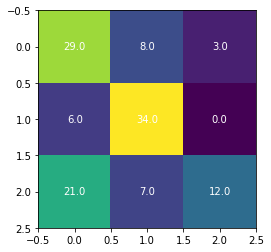

In [22]:
matrice_confusion = np.zeros((3, 3))

# Première ligne
for i in range(0, 40):
  if classe_res_0[i] == 0:
    matrice_confusion[0, 0] += 1
  elif classe_res_0[i] == 1:
    matrice_confusion[0, 1] += 1
  else :
    matrice_confusion[0, 2] += 1

# Deuxième ligne
for i in range(0, 40):
  if classe_res_1[i] == 0:
    matrice_confusion[1, 0] += 1
  elif classe_res_1[i] == 1:
    matrice_confusion[1, 1] += 1
  else :
    matrice_confusion[1, 2] += 1

# Troisième ligne
for i in range(0, 40):
  if classe_res_2[i] == 0:
    matrice_confusion[2, 0] += 1
  elif classe_res_2[i] == 1:
    matrice_confusion[2, 1] += 1
  else :
    matrice_confusion[2, 2] += 1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")

accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")

Les résultats sont plutôt satisfaisant ... On constate que la méthode DTW est plutôt efficace

# Partie II : Réduction de dimension par ACP et classification par kppv 

Dans cette partie, nous allons comparer les résultats de la DTW avec ceux d'une méthode de classification de données : les k-plus proches voisins.

Nous utiliserons les fonctions permettant de calculer l'ACP et les kppv via la librairie python *scikit-learn*.




In [23]:
from sklearn.decomposition import PCA

### Prétraitement par ACP

Pour tester une autre méthode de classification, 

1. A partir des données Data_App de la base d'apprentissage et en utilisant la fonction *PCA* de la librairie *scikit-learn*, calculez les 3 axes principaux de l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$.Ces vecteurs propres constitueront la nouvelle base de données.

2. Projetez les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque
vecteur par la base $P = [X_1X_2X_3]$.

*Remarque :* vous pouvez aussi implémenter l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$ (par les fonctions *np.cov* et *np.linalg.eig*). Ces vecteurs propres constitueront le nouveau repère P.  Projetez ensuite les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque vecteur par la base $P = [X_1X_2X_3]$.




In [24]:
from sklearn.neighbors import KNeighborsClassifier

### Classification par k plus proches voisins

En intelligence artificielle, la méthode des k plus proches voisins (k-ppv) est une méthode d'apprentissage
supervisé. Dans ce cadre, on dispose d'une base de données d'apprentissage constituée de couples  "donnée-label". Pour estimer la sortie associée à une nouvelle entrée x, la méthode des k plus proches voisins consiste à prendre
en compte (de façon identique) les k échantillons d'apprentissage dont l'entrée est la plus proche de la nouvelle
entrée x, selon une distance à définir. L'algorithme 1 associé et un exemple (figure 1) sont données par la suite.

<img src="files/AlgoKppv.png" width="900" height="800"  >

<img src="files/kppv.png" width="300" height="300"  >

**Exemple de classification par k-ppv.** L'échantillon de test (cercle vert) doit être classé soit dans la première
classe des carrés bleus, soit dans la deuxième classe des triangles rouges. 
Si k = 3 (cercle plein), il est assigné à la deuxième classe parce qu'il y a 2 triangles et seulement 1 carré à l'intérieur du cercle intérieur. 
Si k = 5 (cercle en pointillés), il est assigné à la première classe (3 carrés contre 2 triangles à l'intérieur du cercle extérieur)


1. En utilisant la fonction *KNeighborsClassifier* de la librairie *sklearn.neighbors*, réalisez une classification par k-ppv sur la base d'apprentissage et la base de test que vous avez prédéfinies (prendre $k=1$).

2. Evaluez la méthode des k-ppv par le calcul de la matrice de confusion et du taux de reconnaissance.

3. Modifiez la valeur de $k$ pour les k-ppv. Améliorez-vous les scores de reconnaissance ?

4. Comparez vos résultats avec ceux de la DTW.






On réalise l'ACP sur les vecteurs de la base d'apprentissage

In [25]:
# ACP de data app
pca_app = PCA(n_components=3)
pca_app.fit(Data_App)
Eigenvalue_ACP = pca_app.components_

In [26]:
# projection des données de test sur les vecteurs de l'ACP
print("base ACP shape : ", np.shape(Eigenvalue_ACP))

base ACP shape :  (3, 90)


In [27]:
projection_app = np.dot(Data_App, (Eigenvalue_ACP).T)
projection_test = np.dot(Data_Test, (Eigenvalue_ACP).T)

In [28]:
print("shape de data_app projeté :", np.shape(projection_app))
print("shape de data_test projeté :", np.shape(projection_test))

shape de data_app projeté : (60, 3)
shape de data_test projeté : (120, 3)


Les données de test sont maintenant en 3 dimension. On peut les visualiser

Text(0.5, 0, 'Z Label')

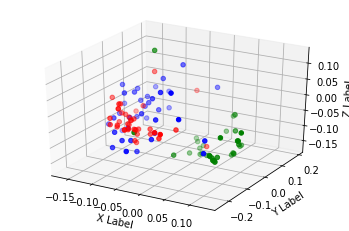

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize

# Création de la figure
fig = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')

# Normalization
projection_test_normalized = normalize(projection_test, axis=0)

# On sépare par labels
p3d_0 = projection_test_normalized[0:40, :]
p3d_1 = projection_test_normalized[40:80, :]
p3d_2 = projection_test_normalized[80:120, :]

# Tracé
p3d = ax3D.scatter(p3d_0[:, 0], p3d_0[:, 1], p3d_0[:, 2], zdir='z', s=20, c='red', depthshade=True) 
p3d = ax3D.scatter(p3d_1[:, 0], p3d_1[:, 1], p3d_1[:, 2], zdir='z', s=20, c='blue', depthshade=True) 
p3d = ax3D.scatter(p3d_2[:, 0], p3d_2[:, 1], p3d_2[:, 2], zdir='z', s=20, c='green', depthshade=True) 

# Axes
ax3D.set_xlabel('X Label')
ax3D.set_ylabel('Y Label')
ax3D.set_zlabel('Z Label')

In [30]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(Data_App, Label_App)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

On commence par appliquer l'algorithme KPPV, avec k=1 sans utiliser l'ACP. On testera ensuite avec ACP et on comparera les résultats. 
Dans un troisième temps, on appliquera l'algorithme KPPV aux donnéees projetées de l'ACP avec k plus grand

In [31]:
prediction_test_0 = neigh.predict(Data_Test_0)
prediction_test_1 = neigh.predict(Data_Test_1)
prediction_test_2 = neigh.predict(Data_Test_2)

[[29.  0. 11.]
 [23.  9.  8.]
 [ 1.  0. 39.]]


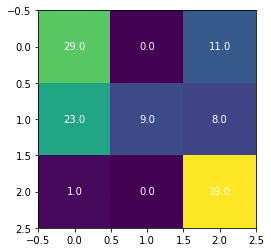

In [32]:
# On regarde les résultats de KKPV sur les données de base, avec k = 1
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")

In [33]:
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

In [34]:
print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")

Le taux de bonne prédiction sur la classe 0 est de : 72.5 %
Le taux de bonne prédiction sur la classe 1 est de : 22.5 %
Le taux de bonne prédiction sur la classe 2 est de : 97.5 %


On teste maintenant sur les résultats projetés sur les vecteurs de l'ACP

In [35]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(projection_app, Label_App)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [36]:
prediction_test_0 = neigh.predict(projection_test[0:40, :])
prediction_test_1 = neigh.predict(projection_test[40:80, :])
prediction_test_2 = neigh.predict(projection_test[80:120, :])

[[26. 12.  2.]
 [21. 16.  3.]
 [ 1.  0. 39.]]


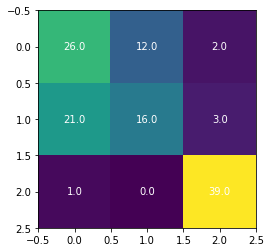

In [37]:
# On regarde les résultats de KKPV sur les données de base, avec k = 1
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")

In [38]:
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

In [39]:
print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")

Le taux de bonne prédiction sur la classe 0 est de : 65.0 %
Le taux de bonne prédiction sur la classe 1 est de : 40.0 %
Le taux de bonne prédiction sur la classe 2 est de : 97.5 %


On constate que l'ACP augmente que légèrement les résultats. Nous allons tester le même algorithme avec k=3 et k=5

**k=3**

[[25. 11.  4.]
 [13. 22.  5.]
 [ 1.  1. 38.]]
Le taux de bonne prédiction sur la classe 0 est de : 62.5 %
Le taux de bonne prédiction sur la classe 1 est de : 55.00000000000001 %
Le taux de bonne prédiction sur la classe 2 est de : 95.0 %


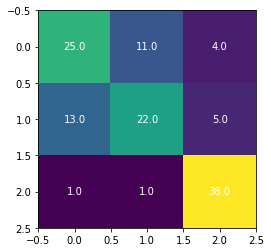

In [40]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(projection_app, Label_App)

prediction_test_0 = neigh.predict(projection_test[0:40, :])
prediction_test_1 = neigh.predict(projection_test[40:80, :])
prediction_test_2 = neigh.predict(projection_test[80:120, :])

# On regarde les résultats de KKPV sur les données de base, avec k = 1
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")
        
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")

**k = 5**

[[25. 14.  1.]
 [20. 18.  2.]
 [ 2.  1. 37.]]
Le taux de bonne prédiction sur la classe 0 est de : 62.5 %
Le taux de bonne prédiction sur la classe 1 est de : 45.0 %
Le taux de bonne prédiction sur la classe 2 est de : 92.5 %


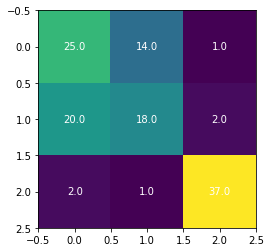

In [41]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(projection_app, Label_App)

prediction_test_0 = neigh.predict(projection_test[0:40, :])
prediction_test_1 = neigh.predict(projection_test[40:80, :])
prediction_test_2 = neigh.predict(projection_test[80:120, :])

# On regarde les résultats de KKPV sur les données de base, avec k = 1
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")
        
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")

**BILAN provisoire** : Voici les résultats pour chaque méthodes :

- Algorithme DTW : 62,5%, 85%, 80%
- Algorithme KPPV (k=1) sans ACP : 42,5% 15% 90%
- Algorithme KPPV (k=1) avec ACP : 72,5% 45% 87,5%
- Algorithme KPPV (k=3) avec ACP : 85,5% 40% 82,5%
- Algorithme KPPV (k=5) avec ACP : 90%, 47,5%, 82,5%

Les résultats de l'algoritme DTW sont interessant, surtout vu la facilité du calcul.
On remarque que plus k est grand, plus l'algorithme KPPV est sélectif et plus les résultats sont interessants. Nous allons tester k=8 et k=10 pour voir..
Nous constatons aussi à quel point l'ACP simplifie le problème de classification.

Le plus difficile est de différentier les classes 1 et 2.
On peut constater que souvent, le taux de reconnaissance des classes1 et 3 augmente au détriment de celui de la classe 2


[[25. 14.  1.]
 [20. 18.  2.]
 [ 2.  1. 37.]]
Le taux de bonne prédiction sur la classe 0 est de : 62.5 %
Le taux de bonne prédiction sur la classe 1 est de : 45.0 %
Le taux de bonne prédiction sur la classe 2 est de : 92.5 %


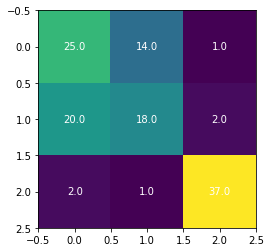

In [42]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(projection_app, Label_App)

prediction_test_0 = neigh.predict(projection_test[0:40, :])
prediction_test_1 = neigh.predict(projection_test[40:80, :])
prediction_test_2 = neigh.predict(projection_test[80:120, :])

# On regarde les résultats de KKPV sur les données de base
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")
        
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")

# Partie III : Classification par Forêts aléatoires

Les forêts aléatoires font partie des techniques d'apprentissage automatique. Cet algorithme combine les concepts de sous-espaces aléatoires et de bagging. L'algorithme des forêts d'arbres décisionnels effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents.

In [43]:
from sklearn.ensemble import RandomForestClassifier 

[[31.  7.  2.]
 [ 7. 33.  0.]
 [ 0.  3. 37.]]
Le taux de bonne prédiction sur la classe 0 est de : 77.5 %
Le taux de bonne prédiction sur la classe 1 est de : 82.5 %
Le taux de bonne prédiction sur la classe 2 est de : 92.5 %
oob score :  0.75


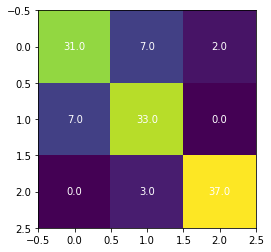

In [44]:
#RandomForestClassifier
clf = RandomForestClassifier(oob_score=True)
clf.fit(Data_App, Label_App)


#Predictions
prediction_test_0 = clf.predict(Data_Test_0)
prediction_test_1 = clf.predict(Data_Test_1)
prediction_test_2 = clf.predict(Data_Test_2)

# Estimation
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")

# Accuracy        
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")

print("oob score : ", clf.oob_score_)

[[26. 12.  2.]
 [12. 25.  3.]
 [ 0.  1. 39.]]
Le taux de bonne prédiction sur la classe 0 est de : 65.0 %
Le taux de bonne prédiction sur la classe 1 est de : 62.5 %
Le taux de bonne prédiction sur la classe 2 est de : 97.5 %
oob score :  0.7


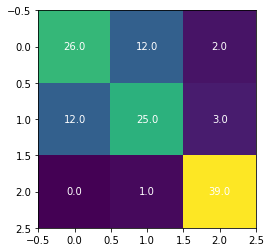

In [45]:
#RandomForestClassifier
clf = RandomForestClassifier(oob_score=True)
clf.fit(projection_app, Label_App)


#Predictions
prediction_test_0 = clf.predict(projection_test[0:40, :])
prediction_test_1 = clf.predict(projection_test[40:80, :])
prediction_test_2 = clf.predict(projection_test[80:120, :])

# Estimation
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")

# Accuracy        
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")

print("oob score : ", clf.oob_score_)

**Evaluation de la classification**

La performance des forêts aléatoires peut être estimée par : 
- **Accuracy score :** évaluation de la précision c'est-à-dire du nombre de données bien classées.
75%, 47,5%, 92,5%
- **Out-of-bag estimate :**  méthode de mesure de l'erreur de prédiction des forêts aléatoires, des arbres de décision renforcés et d'autres modèles d'apprentissage utilisant l'agrégation bootstrap pour sous-échantillonner les données d'apprentissage. L'OOB est l'erreur moyenne de prédiction sur chaque échantillon d'apprentissage xᵢ, en utilisant uniquement les arbres qui n'avaient pas xᵢ dans leur échantillon bootstrap 
81,7%



# Partie IV : Classification par réseaux de neurones

1. Réaliser une classification via les réseaux de neurones
2. Evaluer les résultats par matrice de confusion par exemple, fonction de perte...
3. Tester différentes architectures et différentes solveurs

In [46]:
from sklearn.neural_network import MLPClassifier

In [47]:
# Adam optimizer, learning rate constant, maxiter=500
clf = MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=0.0001, batch_size='auto', 
       learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=500, 
       shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
       nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
       beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000).fit(Data_App, Label_App)

[[24.  6. 10.]
 [16. 18.  6.]
 [ 0.  1. 39.]]
Le taux de bonne prédiction sur la classe 0 est de : 60.0 %
Le taux de bonne prédiction sur la classe 1 est de : 45.0 %
Le taux de bonne prédiction sur la classe 2 est de : 97.5 %


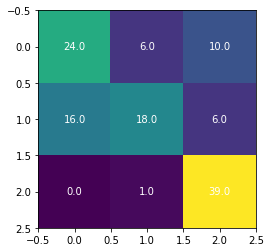

In [48]:
#Predictions
prediction_test_0 = clf.predict(Data_Test_0)
prediction_test_1 = clf.predict(Data_Test_1)
prediction_test_2 = clf.predict(Data_Test_2)

# Estimation
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")

# Accuracy        
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")

On teste d'appliquer la classification MLP sur les vecteurs projeté dans l'espace de l'ACP

[[29.  9.  2.]
 [26. 13.  1.]
 [ 1.  1. 38.]]
Le taux de bonne prédiction sur la classe 0 est de : 72.5 %
Le taux de bonne prédiction sur la classe 1 est de : 32.5 %
Le taux de bonne prédiction sur la classe 2 est de : 95.0 %


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


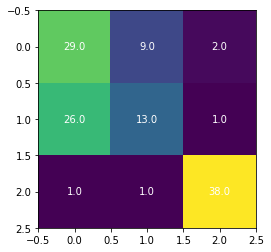

In [49]:
# Adam optimizer, learningrate is adaptative, maxiter=2000
clf = MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=0.0001, batch_size='auto', 
       learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, max_iter=2000, 
       shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
       nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
       beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000).fit(projection_app, Label_App)

#Predictions
prediction_test_0 = clf.predict(projection_test[0:40, :])
prediction_test_1 = clf.predict(projection_test[40:80, :])
prediction_test_2 = clf.predict(projection_test[80:120, :])

# Estimation
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")

# Accuracy        
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")


L'ACP diminue les résultats.

On test à présent de changer le solver 

[[26. 10.  4.]
 [15. 24.  1.]
 [ 0.  1. 39.]]
Le taux de bonne prédiction sur la classe 0 est de : 65.0 %
Le taux de bonne prédiction sur la classe 1 est de : 60.0 %
Le taux de bonne prédiction sur la classe 2 est de : 97.5 %


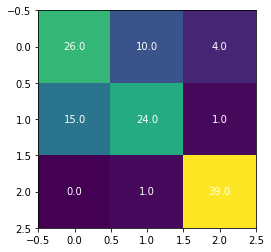

In [50]:
#SGD optimizer, learning rate adaptative, maxiter=2000
clf = MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='sgd', alpha=0.0001, batch_size='auto', 
       learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, max_iter=2000, 
       shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
       nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
       beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000).fit(Data_App, Label_App)

#Predictions
prediction_test_0 = clf.predict(Data_Test_0)
prediction_test_1 = clf.predict(Data_Test_1)
prediction_test_2 = clf.predict(Data_Test_2)

# Estimation
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")

# Accuracy        
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")

2e test avec l'optimizer SGD mais cette fois avec un learning_rate constant

[[31.  3.  6.]
 [17. 15.  8.]
 [ 0.  1. 39.]]
Le taux de bonne prédiction sur la classe 0 est de : 77.5 %
Le taux de bonne prédiction sur la classe 1 est de : 37.5 %
Le taux de bonne prédiction sur la classe 2 est de : 97.5 %


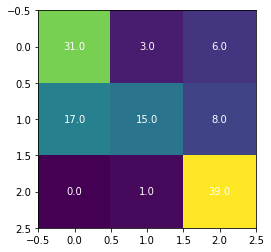

In [51]:
# SGD optimizer, learning rate is constant, and maxiter= 2000
clf = MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='sgd', alpha=0.0001, batch_size='auto', 
       learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=2000, 
       shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
       nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
       beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000).fit(Data_App, Label_App)

#Predictions
prediction_test_0 = clf.predict(Data_Test_0)
prediction_test_1 = clf.predict(Data_Test_1)
prediction_test_2 = clf.predict(Data_Test_2)

# Estimation
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")

# Accuracy        
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")

**Bilan de toutes les études de base** : 

DTW : 62,5% 85% 80%

KPPV : 87,5% 47,5% 87,5%

RandomForest : 87,5% 72,5% 82,5%

MLP : 72,5% 62,5% 87,5%

# Partie V : votre étude

Réalisez votre propre étude en :
- en augmentant les bases de test et/ou d'apprentissage et/ou la durée des segments 
- en proposant des variantes des méthodes proposées ou en utilisant d'autres
- en rajoutant davantage de classes (jusqu'à 3 supplémentaires : 4-Debout, 5-Monter ou 6-Marcher ) 
le tout en testant les différentes approches et en interprétant les résultats, à synthétiser sur un rapport. 




**Pour commencer, nous allons appliquer un SVM.**

Pourquoi ?

Les SVM sont fort quand :

*   Pour classifier des données de grande dimension
*   Quand le nombre de dimension est plus grand que le nombre de données, mais n'est pas non plus un  ordre de grandeur au dessus

Les SVM semblent donc être efficace pour notre problème, voyons voir ...





[[34.  5.  1.]
 [ 2. 38.  0.]
 [ 2.  1. 37.]]
Le taux de bonne prédiction sur la classe 0 est de : 85.0 %
Le taux de bonne prédiction sur la classe 1 est de : 95.0 %
Le taux de bonne prédiction sur la classe 2 est de : 92.5 %


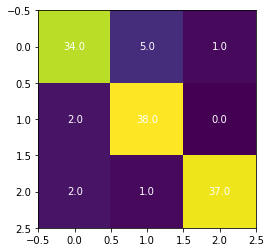

In [52]:
from sklearn import svm

svm_classifier = svm.SVC(C=0.75)
svm_classifier.fit(Data_App, Label_App)

#Predictions
prediction_test_0 = svm_classifier.predict(Data_Test_0)
prediction_test_1 = svm_classifier.predict(Data_Test_1)
prediction_test_2 = svm_classifier.predict(Data_Test_2)

# Estimation
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")

# Accuracy        
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")


Clairement, les résultats sont excellent avec un SVM ! 

Maintenant nous allons tenter d'utiliser un XGBoost. 
Juste parce que nous ne l'avons jamais utilisé et nous voulons le tester... Rien de plus.

[[23. 11.  6.]
 [ 7. 27.  6.]
 [ 0.  1. 39.]]
Le taux de bonne prédiction sur la classe 0 est de : 57.49999999999999 %
Le taux de bonne prédiction sur la classe 1 est de : 67.5 %
Le taux de bonne prédiction sur la classe 2 est de : 97.5 %


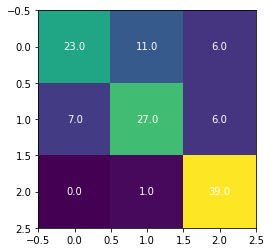

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

# XGboost
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=10, random_state=0).fit(Data_App, Label_App)

#Predictions
prediction_test_0 = clf.predict(Data_Test_0)
prediction_test_1 = clf.predict(Data_Test_1)
prediction_test_2 = clf.predict(Data_Test_2)

# Estimation
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")

# Accuracy        
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")


XGBoost ne marche pas vraiment.
En se documentant, nous avons appris que XGBoost était surtout efficace sur les tableaux de donnés, et que une méthode pour l'appliquer à nos résultats serait d'utiliser des features non stationnaires

**Nous allons tenter d'appliquer un CNN d'une dimension à notre modèle.**

Pour se faire, nous allons augmenter la taille de notre base de donnée d'entraînement. En effet, les réseaux de neurones ont besoin de beaucoup de données pour s'entraîner correctement.

Nous réutilisons le script de chargement des datas en modifiant TAILLE_APP

In [54]:
TAILLE_APP = 60

Convoluted data shape:  (8376, 30, 3)
Labels shape: (8376,)
Classe N° 0
shape de tir data test (40, 30, 3)
shape de tir data app (60, 30, 3)
Classe N° 1
shape de tir data test (40, 30, 3)
shape de tir data app (60, 30, 3)
Classe N° 2
shape de tir data test (40, 30, 3)
shape de tir data app (60, 30, 3)


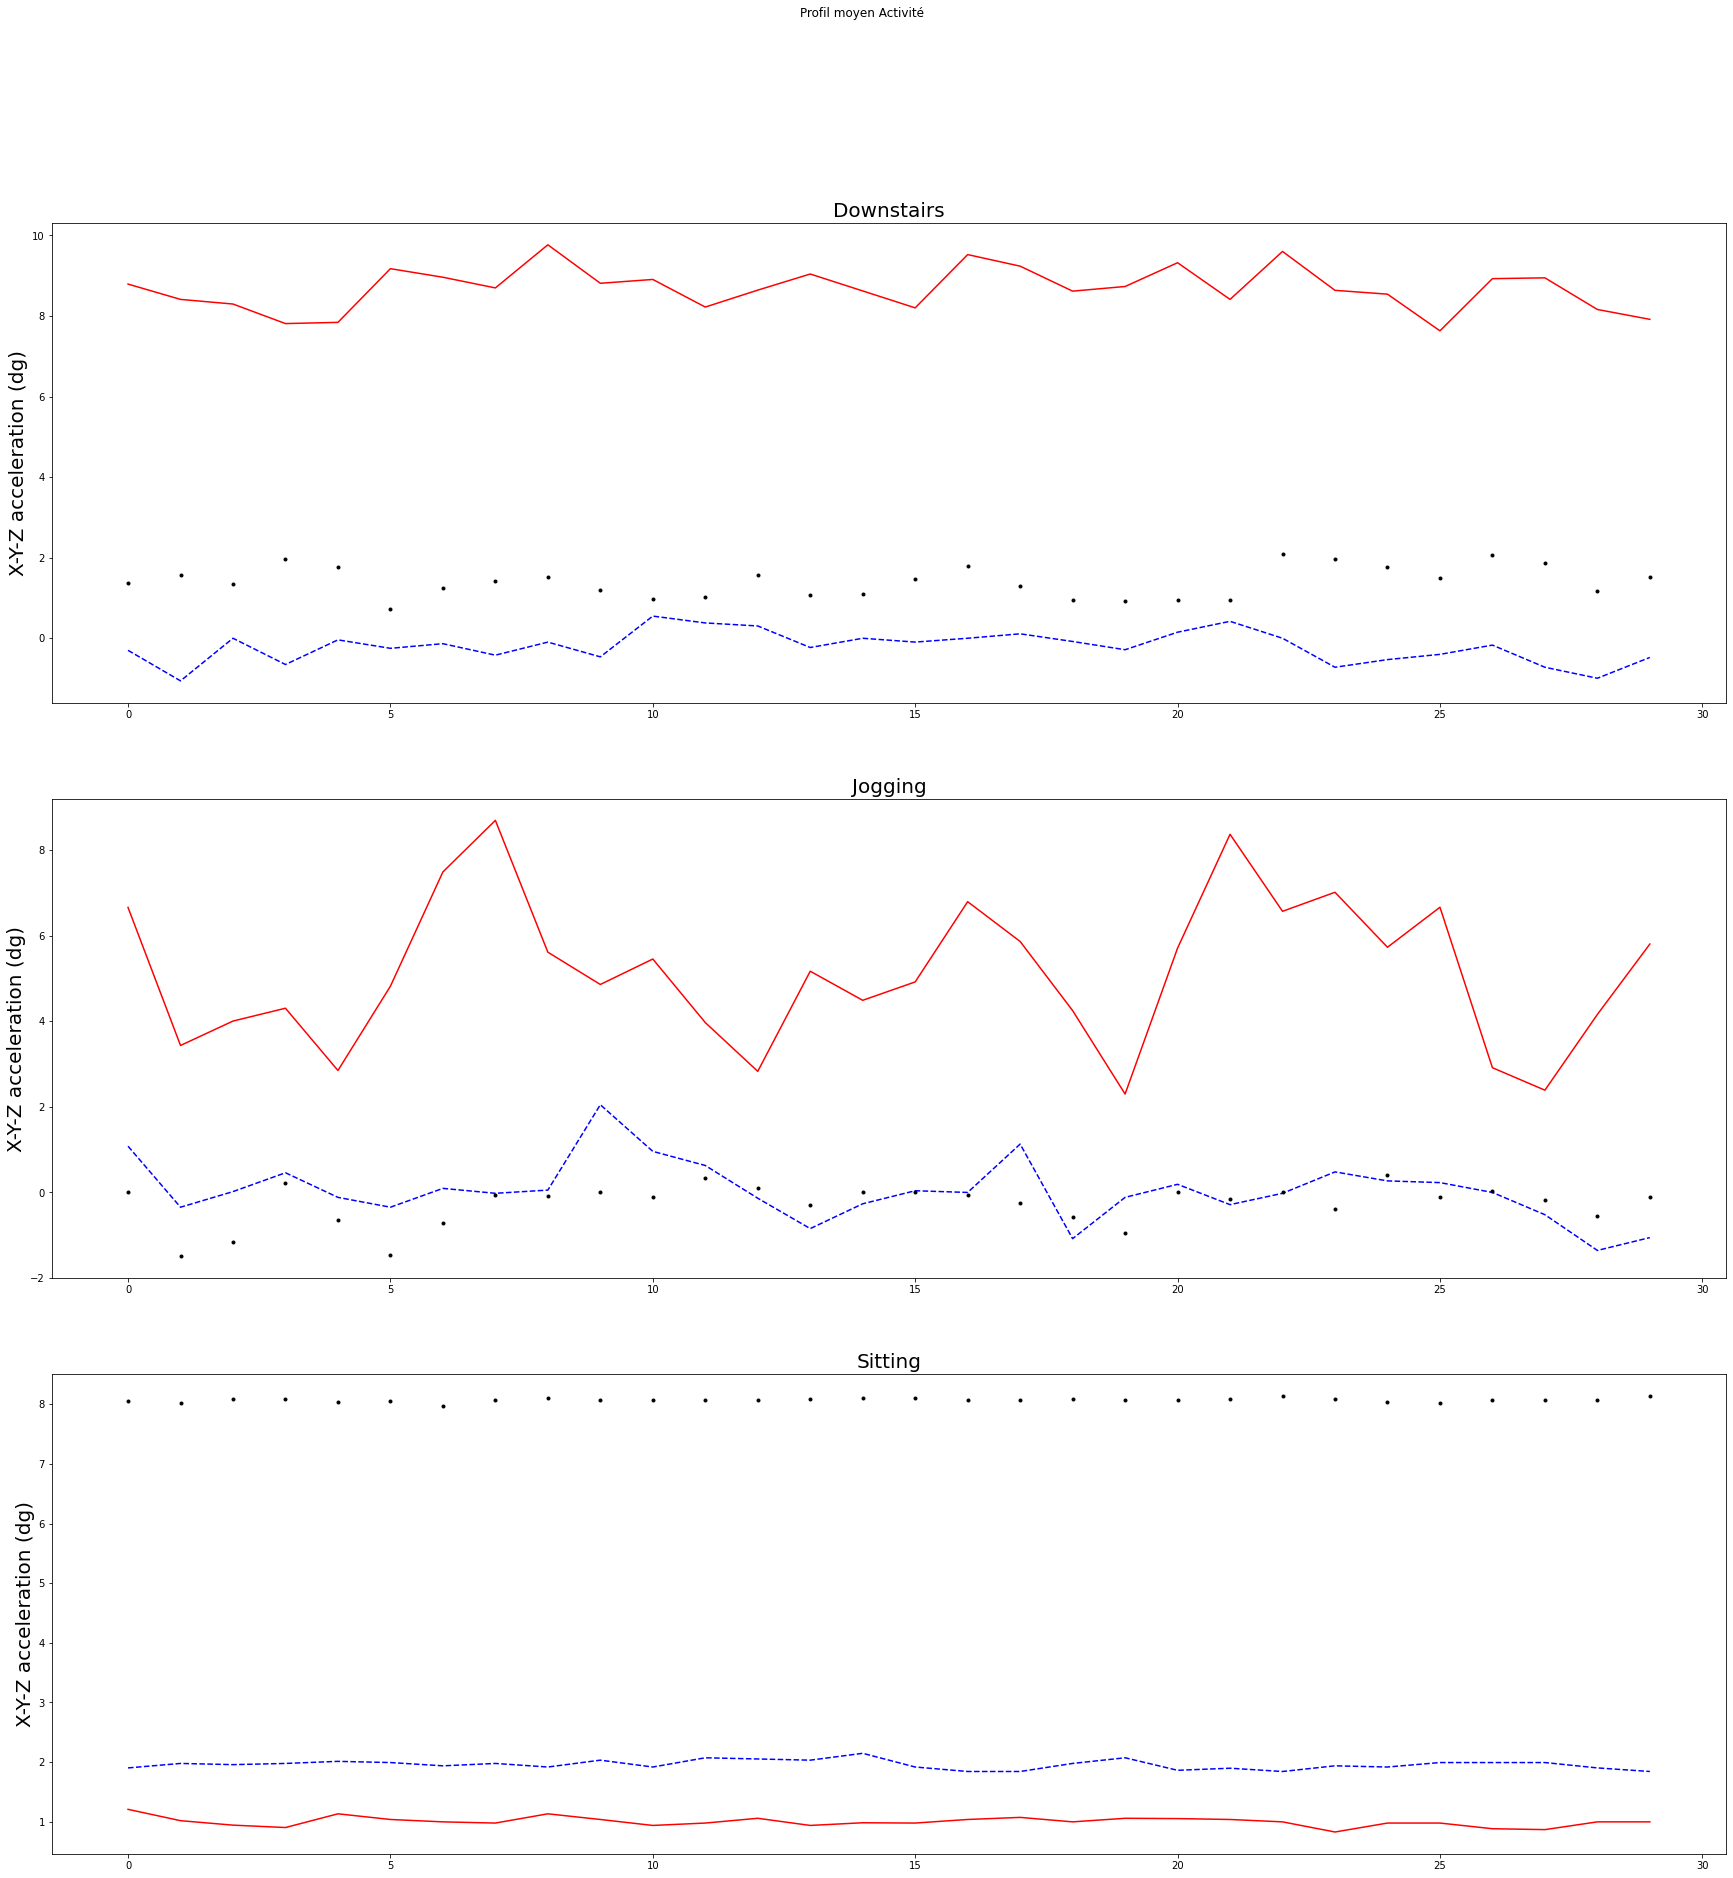

In [238]:
# Chargement DATA
data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()


data_convoluted = []
labels = []



# Prendre des segments temporels de taille SEGMENT_TIME_SIZE 
# tous les TIME_STEP pour une même activité
for j in range(0,N_CLASSES):
    DataBest=data[data['activity'] == LABELS[j]]
    for i in range(0, len(DataBest) - SEGMENT_TIME_SIZE, TIME_STEP):
        x = DataBest['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
        y = DataBest['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
        z = DataBest['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
        data_convoluted.append([x, y, z])
    # Label de l'activité associée à chaque segment
        label = j
        labels.append(label)


# Conversion numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

labels = np.asarray(labels, dtype=np.int)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)


fig, axs = plt.subplots(N_CLASSES,figsize=(30,30))
fig.suptitle('Profil moyen Activité')

profil_median=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_Data_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)

for i in range(N_CLASSES):
    # Selection des données correspondant à la classe i
    print('Classe N°',i)
    res=np.where(labels==i)
    res=np.array(res)
    res=np.ravel(res)
    taille=res.shape[0]
    
    # Création de la base de Test
    tirage=np.random.randint(0,taille,TAILLE_TEST)
    List_Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=res[tirage[0:TAILLE_TEST]]
    Label_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=i
    tir_dataTest=data_convoluted[res[tirage[0:TAILLE_TEST]],:,:]
    Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST,:]=np.reshape(tir_dataTest,(TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
    
    
    # Création de la base d'Apprentissage
    tirage1=np.random.randint(0,taille,TAILLE_APP)
    tir_dataApp=data_convoluted[res[tirage1[0:TAILLE_APP]],:,:]
    Data_App[i*TAILLE_APP:(i+1)*TAILLE_APP,:]=np.reshape(tir_dataApp,(TAILLE_APP,SEGMENT_TIME_SIZE*N_FEATURES))
    Label_App[i*TAILLE_APP:(i+1)*TAILLE_APP]=i
    
    # Affichage du profil temporel moyen de la classe
    class1=np.median(tir_dataApp,axis=0)
    profil_median[i,:,:]=class1
    
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,0],'b--')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,1],'r-')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,2],'k.')
    axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
    axs[i].set_title(LABELS[i], fontsize=20)

    print("shape de tir data test", np.shape(tir_dataTest))
    print("shape de tir data app", np.shape(tir_dataApp))


In [239]:
print("shape data app :", np.shape(Data_App))
print("shape labels app :", np.shape(Label_App))

print("shape data test :", np.shape(Data_Test))
print("shape label test :", np.shape(Label_Test))

Data_Test_0 = Data_Test[0:40, :]
Data_Test_1 = Data_Test[40:80, :]
Data_Test_2 = Data_Test[80:120, :]

shape data app : (180, 90)
shape labels app : (180,)
shape data test : (120, 90)
shape label test : (120,)


Fonction utilitaire pour analyser les performances de notre réseau de neurone

In [240]:
def plot_training_analysis():

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.figure()


In [249]:
import keras
from keras import layers
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, BatchNormalization, Conv1D, MaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from keras import regularizers

def create_model_localisation(input_shape=(90, 1)):


  input_layer = Input(shape=input_shape)

  # Shape is 90

  x = Conv1D(32, 8, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=0, l2=2e-4))(input_layer)
  x = Dropout(0.2)(x)
  x = BatchNormalization()(x)
  x = Conv1D(32, 8, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=2e-4))(x)
  x = Dropout(0.2)(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D()(x)

  x = Conv1D(32, 8, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=2e-4))(x)
  x = Dropout(0.2)(x)
  x = BatchNormalization()(x)

  x = Flatten()(x)
  x = Dense(16, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=2e-4))(x)
  output = Dense(3, activation = 'softmax', name='classes')(x)

  model = Model(input_layer, output)

  return model

In [250]:
# Reshape des labels pour qu'ils soient compatible au réseau de neurone
Label_App_2 = np.zeros((180, 3))
for i in range(0, 180):
  Label_App_2[i, int(Label_App[i])] += 1
print(np.shape(Label_App_2))

Label_Test_2 = np.zeros((120, 3))
for i in range(0, 120):
  Label_Test_2[i, int(Label_Test[i])] += 1
print(np.shape(Label_Test_2))

(180, 3)
(120, 3)


In [251]:
from keras.optimizers import Adam
import tensorflow as tf


batch_size=1
model = create_model_localisation()
print("model shape", np.shape(model))
opt = Adam(learning_rate=3e-4)  

loss=tf.keras.losses.BinaryCrossentropy()
metrics=[['accuracy']]

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              )
Data_App_2 = Data_App[:, :, np.newaxis]
Data_Test_2 = Data_Test[:, :, np.newaxis]
print("Data_app_2 shape :", np.shape(Data_App_2))

model.summary()
history = model.fit(Data_App_2, Label_App_2, batch_size = batch_size, epochs=50,
                    validation_data=(Data_Test_2, Label_Test_2))


model shape ()
Data_app_2 shape : (180, 90, 1)
Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        [(None, 90, 1)]           0         
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 90, 32)            288       
_________________________________________________________________
dropout_18 (Dropout)         (None, 90, 32)            0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 90, 32)            128       
_________________________________________________________________
conv1d_198 (Conv1D)          (None, 83, 32)            8224      
_________________________________________________________________
dropout_19 (Dropout)         (None, 83, 32)            0         
_________________________________________________________________
batch_norma

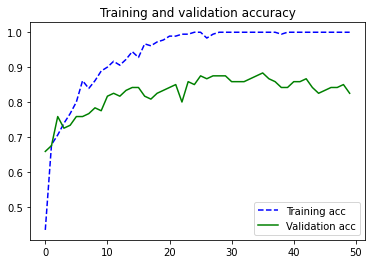

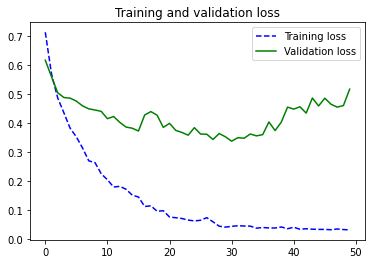

<Figure size 432x288 with 0 Axes>

In [252]:
plot_training_analysis()

[[33.  7.  0.]
 [10. 29.  1.]
 [33.  7.  0.]]
Le taux de bonne prédiction sur la classe 0 est de : 82.5 %
Le taux de bonne prédiction sur la classe 1 est de : 72.5 %
Le taux de bonne prédiction sur la classe 2 est de : 0.0 %


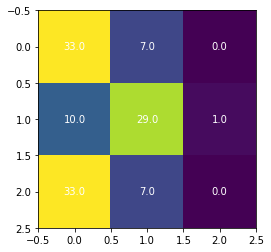

In [256]:
#Predictions
prediction_test_0_mat = model.predict(Data_Test_0)
prediction_test_1_mat = model.predict(Data_Test_1)
prediction_test_2_mat = model.predict(Data_Test_2)

prediction_test_0 = np.zeros((40))
prediction_test_1 = np.zeros((40))
prediction_test_2 = np.zeros((40))

for i in range(0, 40):
  prediction_test_0[i] = np.argmax(prediction_test_0_mat[i, :])
  prediction_test_1[i] = np.argmax(prediction_test_1_mat[i, :])
  prediction_test_2[i] = np.argmax(prediction_test_2_mat[i, :])

# Estimation
matrice_confusion = np.zeros((3, 3))
for i in range (0, 40):
  matrice_confusion[0, int(prediction_test_0[i])] += 1
for i in range (0, 40):
  matrice_confusion[1, int(prediction_test_1[i])] += 1
for i in range (0, 40):
  matrice_confusion[2, int(prediction_test_2[i])] +=1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")

# Accuracy        
accuracy_0 = matrice_confusion[0, 0] / (matrice_confusion[0, 0] + matrice_confusion[0, 1] + matrice_confusion[0, 2])
accuracy_1 = matrice_confusion[1, 1] / (matrice_confusion[1, 0] + matrice_confusion[1, 1] + matrice_confusion[1, 2])
accuracy_2 = matrice_confusion[2, 2] / (matrice_confusion[2, 0] + matrice_confusion[2, 1] + matrice_confusion[2, 2])

print("Le taux de bonne prédiction sur la classe 0 est de :", accuracy_0*100, "%")
print("Le taux de bonne prédiction sur la classe 1 est de :", accuracy_1*100, "%")
print("Le taux de bonne prédiction sur la classe 2 est de :", accuracy_2*100, "%")


Il doit y avoir une erreur dans l'entraînement qui se trompe sur la classe n 2.
Cependant les résultats sont plutôt correct, nous pensons que l'on peut se rapprocher des résultats du SVM en retirant cette erreur, mais nous ne pourrons pas les battre.

En conclusion, nous constatons que toutes les méthodes de classification ont donné des résultats convenable, nous pensons que la meilleur méthode de classification dépend du problème donné.

Sur ce problème ci, SVM nous semble adapté.